In [35]:
import trace.tracepol as tp
import numpy as np
from astropy.io import fits
import itsosspipeline as soss
import sys
import os
import specgen.spgen as spgen
from sys import path

# Imports from the extraction
#from extract.overlap import TrpzOverlap
#from extract.throughput import ThroughputSOSS
#from extract.convolution import WebbKer

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.

import box_kim

In [36]:
# Matplotlib defaults
plt.rc('figure', figsize=(13,7))
plt.rc('font', size=14)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=1)

In [37]:
WORKING_DIR = '/home/kmorel/ongenesis/jwst-user-soss/PHY3030/'

sys.path.insert(0, "/genesis/jwst/jwst-ref-soss/fortran_lib/")

# Read in all paths used to locate reference files and directories
config_paths_filename = os.path.join(WORKING_DIR, 'jwst-mtl_configpath_kim.txt')
pathPars = soss.paths()
soss.readpaths(config_paths_filename, pathPars)

# Create and read the simulation parameters
simuPars = spgen.ModelPars()              # Set up default parameters
simuPars = spgen.read_pars(pathPars.simulationparamfile, simuPars)    # Read in parameter file

spgen.py - warning - fix the bug with orderlist


In [38]:
def normalization(f_lambda, t1, t4):
    """
    Normalize transit light curve by mean during out of transit.
    """
    hors_t = np.concatenate((f_lambda[: t1 + 1], f_lambda[t4:]))
    mean = np.mean(hors_t)
    return f_lambda / mean

def transit_depth(f_lambda, t2, t3):
    """
    Calculates mean flux value during transit.
    """
    return np.mean(f_lambda[t2: t3+1])

def fit_resFunc(coeff, x, y):
    """
    Function to minimize in least square fit for polynomial retrieval.
    """
    p = np.poly1d(coeff)
    return (p(x)) - y

Load simulations

In [39]:
gain = 1.6   # é per adu

# NOISY
noisy_rateints = fits.open(WORKING_DIR + 'IDTSOSS_clear_noisy--photon_rateints.fits')

# Noisy images for extraction
data_noisy = noisy_rateints[1].data     # Images of flux [adu/s]
data_noisy = data_noisy.astype('float64', copy=False)
delta_noisy = noisy_rateints[2].data     # Errors [adu/s]
delta_noisy = delta_noisy.astype('float64', copy=False)

print(np.shape(data_noisy))

dq = noisy_rateints[3].data  # Data quality
i = np.where(dq % 2 != 0)  # Odd values of dq = DO NOT USE these pixels
data_noisy[i[0], i[1], i[2]] = 0.
delta_noisy[i[0], i[1], i[2]] = 0.

# NOISELESS
clear = fits.open(WORKING_DIR + 'IDTSOSS_clear.fits')

data_clear = clear[1].data[:,-1]  # Images of flux [adu/s]  (Last image of each integration)
   
# Convert data from fits files to float (fits precision is 1e-8)
data_noiseless = [im_ord.astype('float64') for im_ord in data_clear]

(4, 256, 2048)


Extraction

In [40]:
# BOX EXTRACTION

# Position of trace for box extraction
x, y, w = box_kim.readtrace(os=1)

# Extractions
fbox_noiseless = np.zeros(shape=(np.shape(data_noiseless)[0], np.shape(data_noiseless)[2]), dtype='float')
fbox_noisy = np.zeros(shape=(np.shape(data_noisy)[0], np.shape(data_noisy)[2]), dtype='float')

radius_pixel = 35  # Radius for box extraction
oversample = simuPars.noversample  # Oversampling of the simulation

for t in range(np.shape(data_noiseless)[0]):  # For each image of the timeseries
    fbox_noiseless[t] = box_kim.flambda_adu(x, data_noiseless[t], y, radius_pixel=radius_pixel) / oversample * gain   # [e⁻/s]
    fbox_noisy[t] = box_kim.flambda_adu(x, data_noisy[t], y, radius_pixel=radius_pixel) / oversample * gain   # [e⁻/s]

In [41]:
lam_array = w

f_array_noiseless = fbox_noiseless
f_array_noiseless = np.nan_to_num(f_array_noiseless)
f_array_noisy = fbox_noisy
f_array_noisy = np.nan_to_num(f_array_noisy)

time = np.arange(f_array_noiseless.shape[0])
time_min = time * 5. * 5.491 / 60.  # [min]

In [42]:
# White light curve
f_white_noiseless = np.sum(f_array_noiseless, axis=1)
f_white_noisy = np.sum(f_array_noisy, axis=1)

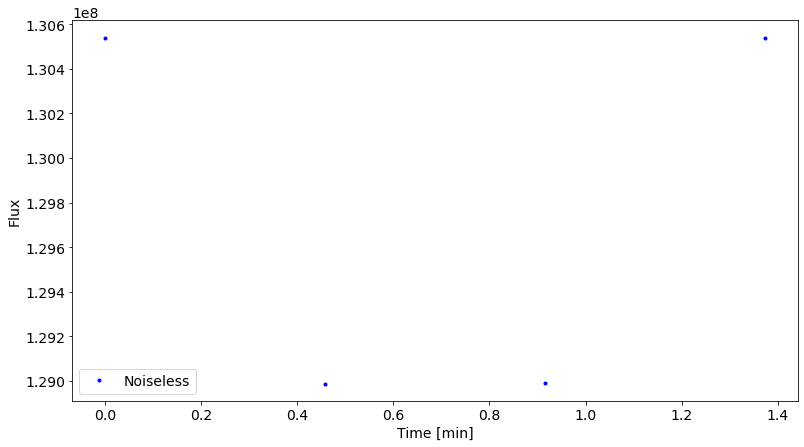

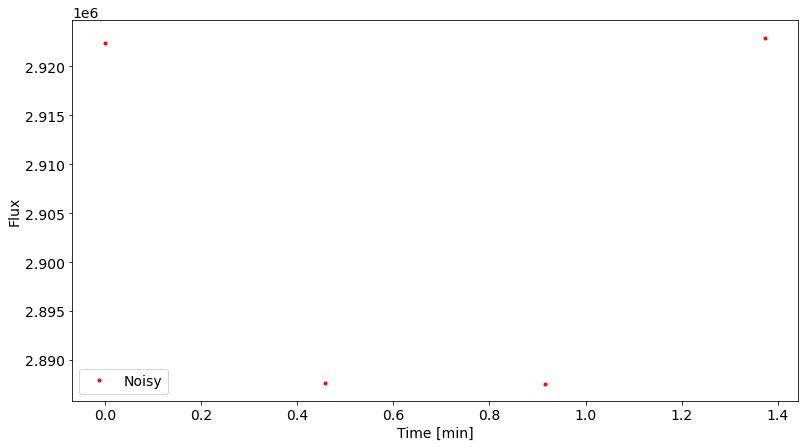

In [43]:
plt.figure()
plt.plot(time_min, f_white_noiseless, '.', color='b', label='Noiseless')
plt.xlabel('Time [min]')
plt.ylabel(r'Flux')
plt.legend()
plt.show()

plt.figure()
plt.plot(time_min, f_white_noisy, '.', color='r', label='Noisy')
plt.xlabel('Time [min]')
plt.ylabel(r'Flux')
plt.legend()
plt.show()